# 22 dimensional toy system setup with a pytorch RCmodel
This notebook will show you the basic usage of arcd, you will learn how to:
- set up an ANN-enhanced TPS simulation of a 22 dimensional toy system from scratch
- run the simulation
- inspect the training process
- (try to) analyze what the ANN learned

## imports, working directory and logging setup

In [1]:
%matplotlib inline

In [2]:
import os
import arcd
import torch
import numpy as np
import matplotlib.pyplot as plt
import openpathsampling as paths
# convenience for the toy dynamics
import openpathsampling.engines.toy as toys
from functools import reduce

Using TensorFlow backend.


In [3]:
# load a helper class for visualization of the toy system
%run resources/toy_plot_helpers.py

In [4]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run resources/logconf.py

In [5]:
# change to the working directory of choice
wdir = '/homeloc/scratch/hejung/arcd_scratch/toys/'
#wdir = None
if wdir is not None:
    os.chdir(wdir)

In [6]:
# you can either modify single values or use it as is to get the same setupt as in the OPS default logging config file
# you could e.g. do LOGCONF['handlers']['stdf']['filename'] = new_name to change the filename of the log
# the default is to create 'simulation.log' and 'initialization.log' in the current working directory
import logging.config
logging.config.dictConfig(LOGCONFIG)

## toy system setup
This is not yet arcd specific, but the general way of setting up an OPS TPS simulation, have a look at the opepathsampling example notebooks for more.

### PES
 - construct a 22 dimensional PES, where the first two dimensions are x and y of the plotted 2D ToyPotential, the remaining 20 dimensions are uncoupled harmonic oscillators with random frequencies to emulate irrelevant coordinates
 - from a previous run in this potential we know: $<t_{TP}>\approxeq 566 ~\mathrm{timesteps} = 11.32 ~\mathrm{units~of~time}$ => any harmonic oszilator with $\omega < 2\pi/T \approxeq 0.555$ has a lower frequency than the transition of interest
 - to challenge the ANN we make sure that the first two harmonic oscillators (i.e. dim 3 and 4) have an $\omega$ smaller than and comparable to the transition frequency respectively


In [7]:
# Construct the PES as a sum of simpler PES
# Toy_PES supports adding/subtracting various PESs. 
# The OuterWalls PES type gives an x^6+y^6 boundary to the system.
n_harmonics = 20
pes_list = []
pes_list += [toys.OuterWalls(sigma=[0.2, 1.0] + [0. for _ in range(n_harmonics)],
                             x0=[0.0, 0.0] + [0. for _ in range(n_harmonics)])
            ]
pes_list += [toys.Gaussian(A=-.7,
                           alpha=[12.0, 12.0] + [0. for _ in range(n_harmonics)],
                           x0=[-.75, -.5] + [0. for _ in range(n_harmonics)])
            ]
pes_list += [toys.Gaussian(A=-.7,
                           alpha=[12.0, 12.0] + [0. for _ in range(n_harmonics)],
                           x0=[.75, .5] + [0. for _ in range(n_harmonics)])
            ]
pes_list += [toys.HarmonicOscillator(A=[0., 0.] + [1./2. for _ in range(n_harmonics)],
                                     omega=[0., 0.] + [0.2, 0.5] + [10.*np.random.ranf() for _ in range(n_harmonics-2)],
                                     x0=[0. for _ in range(n_harmonics + 2)])
            ]

# print the randomly drawn harmonic oszilator periods in case we want to redo exactly this setup 
print('harmonic oscillators omegas:')
print(repr(pes_list[-1].omega))

# construct the 22D PES
pes = reduce(lambda x,y: x+y, pes_list)

# make the same pes again to plot, this time in 2D, i.e. without oszilators
# take the relevant values from pes_list
pes_to_plot = (
    toys.OuterWalls(sigma=pes_list[0].sigma[:2], x0=pes_list[0].x0[:2]) +
    toys.Gaussian(A=pes_list[1].A, alpha=pes_list[1].alpha[:2], x0=pes_list[1].x0[:2]) +
    toys.Gaussian(A=pes_list[2].A, alpha=pes_list[2].alpha[:2], x0=pes_list[2].x0[:2])
)

harmonic oscillators omegas:
array([0.        , 0.        , 0.2       , 0.5       , 0.27356233,
       0.2491535 , 2.97738632, 0.77018269, 5.27523695, 1.05029755,
       3.11349443, 1.03698831, 7.837745  , 3.44037683, 1.35785595,
       5.09186441, 8.84351503, 6.52718138, 6.91293907, 6.16313314,
       6.92029975, 0.42686634])


### setup topology, integrator, template snapshot and OPS-engine

In [8]:
topology=toys.Topology(n_spatial=2 + n_harmonics,
                       masses=np.array([1.0 for _ in range(2 + n_harmonics)]),
                       pes=pes,
                       n_atoms=1
                       )

integ = toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)
options={'integ': integ,
         'n_frames_max': 5000,
         'n_steps_per_frame': 1
         }


toy_eng = toys.Engine(options=options,
                      topology=topology
                      )
toy_eng.initialized = True

template = toys.Snapshot(coordinates=np.array([[-0.75, -0.5] + [0. for _ in range(n_harmonics)]]), 
                         velocities=np.array([[0.0, 0.0] + [0. for _ in range(n_harmonics)]]),
                         engine=toy_eng
                         )
toy_eng.current_snapshot = template

### setup collective variables and states and create an initial TP
Note that we can just 'draw' the initial TP for this potential, ussually you will have to get it previously by doing some enhanced sampling or high temperature run.

In [9]:
def circle(snapshot, center):
    import math
    return math.sqrt((snapshot.xyz[0][0]-center[0])**2 + (snapshot.xyz[0][1]-center[1])**2)

# Collective variables to define the states
opA = paths.CoordinateFunctionCV(name="opA", f=circle, center=[-0.75, -0.5])
opB = paths.CoordinateFunctionCV(name="opB", f=circle, center=[0.75, 0.5])

# State volumes in CV space
stateA = paths.CVDefinedVolume(opA, 0.0, 0.15).named('StateA')
stateB = paths.CVDefinedVolume(opB, 0.0, 0.15).named('StateB')

# collective variable to transform OPS snapshots to model descriptor space,
# i.e. the space in which the model learns
descriptor_transform = paths.FunctionCV('descriptor_transform', lambda s: s.coordinates[0], cv_wrap_numpy_array=True)

In [10]:
# initial TP
initAB = paths.Trajectory([toys.Snapshot(coordinates=np.array([[-0.75 + i/700., -0.5 + i/1000] + [0. for _ in range(n_harmonics)]]), 
                                         velocities=np.array([[1.0, 0.0]  + [0. for _ in range(n_harmonics)]]),
                                         engine=toy_eng
                                        )
                          for i in range(1001)])

# to project 22 dim trajectories to 2dim plot space
def tra_to_2d(tra):
    """
    Extracts the two non harmonic degrees of freedom of a trajectory for ploting.
    """
    snap_list = []
    for s in tra:
        snap_list.append(toys.Snapshot(coordinates=np.array(s.coordinates[:,:2])))
    return paths.Trajectory(snap_list)

### have a look at our potential, states and initial TP

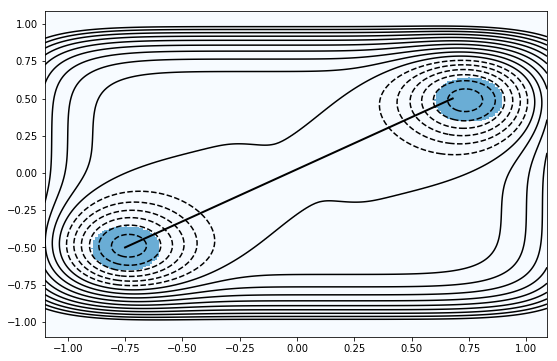

In [11]:
plot = ToyPlot()
plot.contour_range = np.arange(-1.5, 1.0, .1)
plot.add_pes(pes_to_plot)
plot.add_states([stateA, stateB])

# passing the initial TP to bold and not to trajectories,
# because we want it to be....bold :)
fig = plot.plot(bold=[tra_to_2d(initAB)])

## arcd setup

### Create the underlying model to predict/fit the committors
The creation of the model naturally varies depending on the underlying model (e.g. Pytorch ANN) you chose.

In [12]:
# a collection of different pytorch ANN models can be found in arcd.pytorch.networks
# FFNet is a simple 4 layer feedforward network
torch_model = arcd.pytorch.networks.FFNet(n_in=2 + n_harmonics,
                                          # using a single output we will predict only p_B and use a binomial loss
                                          # we could have also used n_out=n_states to use a multinomial loss and predict all states,
                                          # but this is only worthwhile if n_states > 2
                                          n_out=1
                                          )

# move model to GPU if CUDA is available
if torch.cuda.is_available():
    torch_model = torch_model.to('cuda')

# choose and initialize an optimizer to train the model
# Note that this should be done after moving the model where it should live (e.g. 'cuda')
optimizer = torch.optim.Adam(torch_model.parameters(), lr=1e-3)

### wrap the underlying model as `arcd.RCmodel` 
- The subclass of `arcd.RCModel` depends on the underlying model(s). All `arcd.RCModel`s for pytorch can e.g. be found in `arcd.pytorch.rcmodel` but are also imported to the topmodule `arcd.pytorch`, such that you can use them as `arcd.pytorch.MODEL_CLASS`.

- The `arcd.RCModel` and its subclasses is what you will usually be working with when using `arcd`. It is the expected input for the `arcd.ops.RCModelSelector` and `arcd.ops.TrainingHook` classes used for iterative training and also to all analysis methods that can be found in `arcd.analysis`. Normally there will be no need for you to access the underlying models, as all `arcd.RCModels` expose a consistent interface independent of the underlying model. This strict separation enables to easily add other underlying machine learning models to arcd by subclassing `arcd.base.rcmodel.RCModel` and simply adding the required functions without the need to reimplement the iterative training loop and decisions.

In [13]:
# we take an ExpectedEfficiencyPytorchRCModel,
# this RCmodel scales the learning rate by the expected efficiency factor (1 - n_TP_true / n_TP_expected)**2
model = arcd.pytorch.EEPytorchRCModel(nnet=torch_model,
                                      optimizer=optimizer,
                                      ee_params={'lr_0': 1e-3,  # lr = lr_0 * (1 - n_TP_true / n_TP_expected)**2
                                                 'lr_min': 1e-5,  # do not train if lr < lr_min
                                                 'epochs_per_train': 5,  # train for 5 epochs every time we train
                                                 'interval': 3,  # attempt to train after every 3rd MCStep
                                                 'window': 100,  # average expected efficiency factor over 100 MCSteps
                                                },
                                      descriptor_transform=descriptor_transform,  # the function transforming snapshots to descriptors
                                      loss=None  # if loss=None it will choose either binomial or multinomial loss, depending on the number of model outputs,
                                      # but we could have also passed a custom loss function if we wanted to
                                      )

### initialize an empty `arcd.TrainSet`
- The TrainSet is always the same for all RCModels, it stores the shooting points together with corresponding shot_results. It also has some useful methods to iterate over the training data.
- It needs to know about the states, such that it can extract the states reached from given OPS snapshots/trajectories and about the CV transforming molecular coordinates to training descriptors, such that it can calculate and store the training descriptors for each point.

In [14]:
trainset = arcd.TrainSet(states=[stateA, stateB], descriptor_transform=descriptor_transform)

### create `arcd.Trainhook`
This is the object handling the interface between openpathsampling and the `arcd.RCModel`. It will train the model according to the models `train_hook` and `train_decision()` methods and save it after the TPS simulation (and every `save_model_interval` MCSteps). It will also try to load and reset the `arcd.RCModel` if continuing a TPS simulation from file.

In [15]:
trainhook = arcd.ops.TrainingHook(model=model,
                                  trainset=trainset,
                                  save_model_interval=100
                                  )

### create `acrd.ops.RCModelSelector`
This is the object handling the selection of new shooting points according to the current `arcd.RCModel` prediction. It also calculates (part of) the acceptance factor for the TPS simulation. See `openpathsampling.ShootingPointSelector` for more on shooting point selectors in OPS.

In [16]:
selector = arcd.ops.RCModelSelector(model=model,  # always takes a RCModel
                                    # we can greatly speed up rejecting/accepting trial TPS by passing the list of states
                                    # this enables testing if a trial TP is even a TP and calculating the potentially costly
                                    # transformation from Cartesian to descriptor space only if neccessary
                                    # if we are lazy and know that the transformation is fast we can also explicitly pass None
                                    states=[stateA, stateB],
                                    # new shooting points are selected with p_sel(SP) ~ p_lorentz(model.z_sel(SP))
                                    # could also choose 'gaussian'
                                    distribution='lorentzian',
                                    # softness of the selection distribtion,
                                    # lower values result in a sharper concentration around the predicted transition state,
                                    # higher values result in a more uniform selection
                                    scale=1.0,
                                   )

## setup openpathsampling TPS simulation and storage
This is basic openpathsampling stuff, please consult the openpathsampling examples for details on this section.

In [17]:
# velocity randomizer setup
beta = integ.beta
modifier = paths.RandomVelocities(beta=beta, engine=toy_eng)
# shooting strategy: TwoWayShooting
tw_strategy = paths.strategies.TwoWayShootingStrategy(modifier=modifier, selector=selector, engine=toy_eng, group='TwoWayShooting')
# transition network, tells us which transitions to sample
tps = paths.TPSNetwork.from_states_all_to_all([stateA, stateB])
# move scheme, tells us how to do the sampling
move_scheme = paths.MoveScheme(network=tps)
move_scheme.append(tw_strategy)
# this should always be the last added strategy for custom move_schemes, it sorts all previously appended strats when building the tree
move_scheme.append(paths.strategies.OrganizeByMoveGroupStrategy())
move_scheme.build_move_decision_tree()

In [18]:
# get initial conditions sample set from initial TP
initial_conditions = move_scheme.initial_conditions_from_trajectories([initAB])

No missing ensembles.
No extra ensembles.


In [19]:
# create a storage file
storage = paths.Storage('22dim_toy_pytorch.nc', 'w', template=template)

In [20]:
# create a PathSampling
sampler = paths.PathSampling(storage=storage,
                             sample_set=initial_conditions,
                             move_scheme=move_scheme
                             )

In [21]:
# THIS IS IMPORTANT
# make sure we save the descriptor_transform to storage,
# OPS will only save it if any other saved object contains a reference to it
# but we can esily save it ourselfes by doing
storage.save(descriptor_transform)

(store.attributes[PseudoAttribute] : 3 object(s),
 20,
 322933720576570749390591778985789620268)

### arcd specific again: attach the `TrainHook` to the PathSampling such that it can train after every MCStep

In [22]:
sampler.attach_hook(trainhook)

In [23]:
# do 500 MCSteps of TPS
sampler.run(500)

Working on Monte Carlo cycle number 500
Running for 24 minutes 26 seconds -  2.94 seconds per step
Estimated time remaining: 2 seconds
DONE! Completed 500 Monte Carlo cycles.


## Lets have a look at the training process

In [24]:
# train log_decision is a list of lists
# every entry contains [train, lr, epochs] as returned by model.train_decision()
print(model.log_train_decision[-1])

[False, 1.5137026767788675e-06, 5]


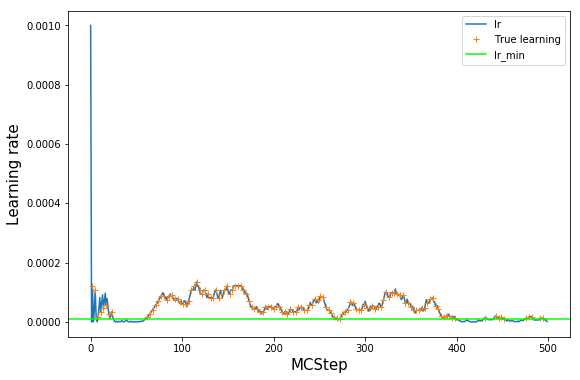

In [25]:
# lets have a look at the value of the learning rate over the course of training
# note however, that we did not train at every step, but just at every interval MCsteps
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

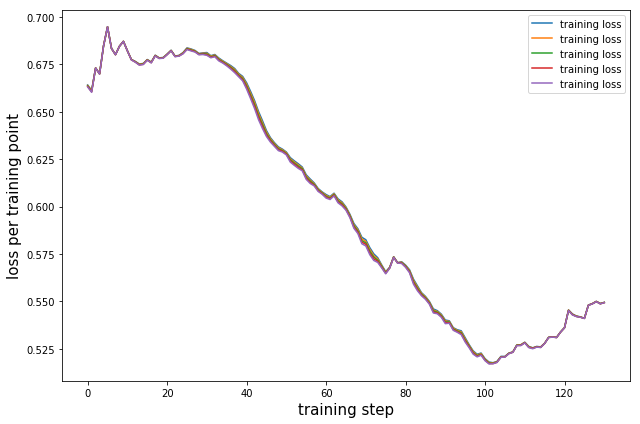

In [26]:
# the model losses at each step where it trained
# this will be epochs_per_training loss values per training
plt.plot(model.log_train_loss, label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('training step', size=15)
plt.tight_layout()

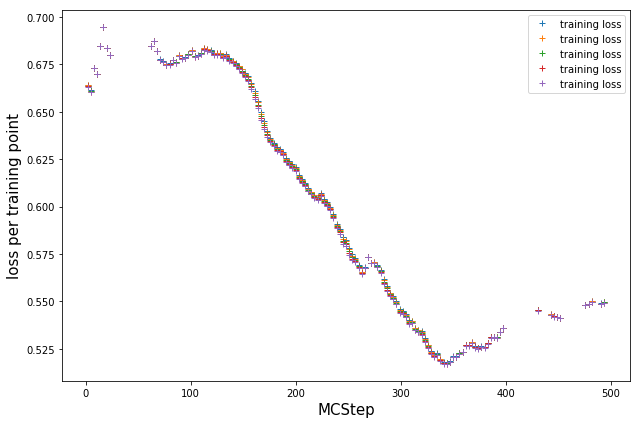

In [43]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

In [28]:
# get the number of accepts from OPS storage
accepts = []
for step in storage.steps:
    if step.change.canonical.accepted:
        accepts.append(1.)
    else:
        accepts.append(0.)

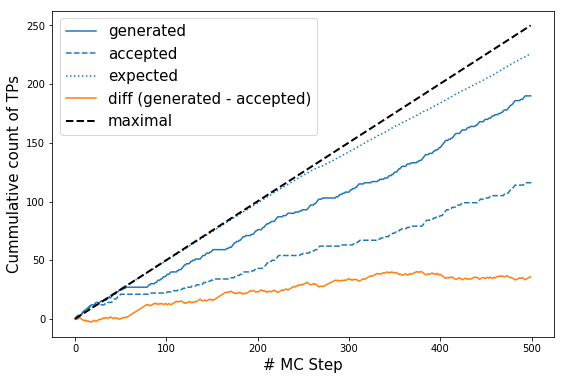

In [29]:
# plot efficiency, expected efficiency and accepts
# Note: this will only work for models with n_out=1, due to the way we calculate p(TP|x)

p_ex = np.array(model.expected_p)

l, = plt.plot(np.cumsum(trainset.transitions), label='generated');
plt.plot(np.cumsum(accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff (generated - accepted)')
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=15);
plt.ylabel('Cummulative count of TPs', size=15)
plt.xlabel('# MC Step', size=15);

## look at what the model learned

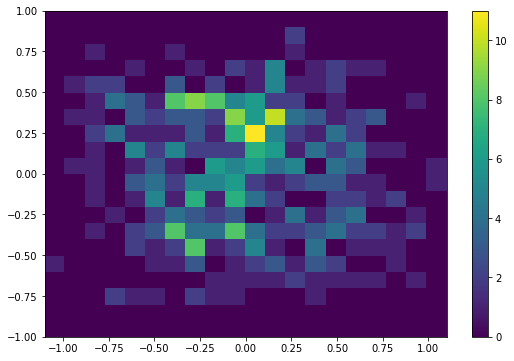

In [30]:
# have a look at the distribution of SPs in the x/y plane
# should show us that the model concentrates the SPs around the transition state in x/y
# Note that this is not really helpful in a molecular setting, as we ussually do not know the projection
# in which the high dimensional descriptor input space reduces to easy relations
# However, for our toy example it can be quite instructive to look at. 

x = np.zeros((len(storage.steps)-1,))
y = np.zeros((len(storage.steps)-1,))
for i, step in enumerate(storage.steps[1:]):
    coords = step.change.canonical.details.shooting_snapshot.coordinates[0]
    x[i] = coords[0]
    y[i] = coords[1]

plt.hist2d(x, y, range=[(-1.1, 1.1),(-1., 1.)], bins=20)
plt.colorbar();

### HIPR - relative input importance analysis

In [31]:
# perform a HIPR analysis of the model over the trainset
hipr = arcd.analysis.HIPRanalysis(model,
                                  trainset,
                                  n_redraw=5,  # setting n_redraw=5 will redraw random values 5 times for every descriptor dimension for every point 
                                  )

In [32]:
hipr_losses = hipr.do_hipr()  # the n_redraw given to do_hipr() directly takes precedence over the one given at init time

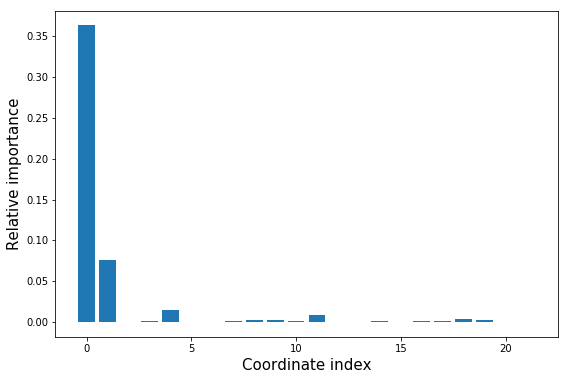

In [33]:
loss_diffs = hipr_losses[:-1] - hipr_losses[-1]  # hipr_losses[-1] is the reference loss over the unaltered trainset

plt.bar(np.arange(len(loss_diffs)), loss_diffs)
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

In [34]:
# sync and close the OPS storage
# not strictly neccessary but a good habit to make sure everything you expect is in there
storage.sync_all()
storage.close()